In [2]:
import pandas as pd
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np 
import sklearn as sk
import seaborn as sns
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import itertools
import warnings
import scipy.signal as sp
import math
from statsmodels.tsa.stattools import acf, pacf
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import datetime
import statistics
from sklearn import linear_model

C:\Users\trevo\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [23]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [3]:
def convert_datetime(dTot):
    
    dTot['Date_Hour'] = pd.to_datetime(dTot.Date) + pd.to_timedelta(dTot.Hour, unit='h')
    
    
    
    dTot = dTot.drop(['Date','Hour'],axis = 1)
    dTot = dTot.set_index('Date_Hour')
    
    return dTot

In [4]:
#importing zonal data from 2015-2017, only taking total consumption
demand2013 = pd.read_csv("ZonalDemands_2013.csv", usecols = [0,1,2])
demand2014 = pd.read_csv("ZonalDemands_2014.csv", usecols = [0,1,2])
demand2015 = pd.read_csv("ZonalDemands_2015.csv", usecols = [0,1,2])
demand2016 = pd.read_csv("ZonalDemands_2016.csv", usecols = [0,1,2])
demand2017 = pd.read_csv("ZonalDemands_2017.csv", usecols = [0,1,2])

#convert to pandas dateTime
demand2013 = convert_datetime(demand2013).resample('D').mean()
demand2014 = convert_datetime(demand2014).resample('D').mean()
demand2015 = convert_datetime(demand2015).resample('D').mean()
demand2016 = convert_datetime(demand2016).resample('D').mean() 

demand2017 = convert_datetime(demand2017).resample('D').mean()

#Remove weekends
#demand2013 = demand2013[demand2013.index.dayofweek < 5]


In [5]:
#1 day ahead
forecast_length = 1
print(len(demand2017))

366


In [34]:
#build models and validate
def test_model (train, test, i):

    #convert by log
    dTot_train_log = np.log(train[i]) # change
   
    #seasonal differencing
    seasons = 12
    dTot_train_log_ewma = dTot_train_log - dTot_train_log.shift(seasons)
    
    #fit model
    mod = sm.tsa.statespace.SARIMAX(dTot_train_log_ewma.resample('D'),
                                    order=(1, 1, 1),
                                    seasonal_order=(0, 1, 1, seasons),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()

 
    #forecast
    forecast_log_diff = pd.Series(results.get_forecast(steps = forecast_length).predicted_mean, copy = True)
    forecast_log_diff.index  = test[i].index #.resample('D').mean()
    
    #Remove differencing 
    forecast_log =  forecast_log_diff + dTot_train_log.shift(seasons).iloc[len(train[i])-1] #try mean?
    
    #Remove log
    forecast =  pd.Series(np.exp(forecast_log), index=forecast_log.index)

    return forecast


In [35]:
#Spilt into train/test
train = []
test = []
trans = []
results = []

start = 2 #if 1 delete append 2017 in train, remember to change for loop length i.e 260 if 1

ctr = start+forecast_length #forecast_length

train.append(pd.concat([demand2016,demand2017.iloc[0:start]])) #,demand2017.iloc[0:130] summer only
test.append(demand2017.iloc[start]) #[0:forecast_length]
results.append(test_model(train,test,0))

#int(round(260/forecast_length))

for i in range(1,2): #(1,260) summer only
    
    train.append(train[i-1].append(test[i-1]))
    test.append(demand2017.iloc[ctr])
    ctr = ctr + forecast_length
    trans.append(test_model(train,test,i))
   
    

#print(results)
#print(np.mean(results))
#print(np.std(results))
#plt.hist(results)

C:\Users\trevo\Anaconda3\lib\site-packages\numpy\core\numeric.py:544: FutureWarning: 
.resample() is now a deferred operation
You called __array__(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  return array(a, dtype, copy=False, order=order, subok=True)


911.3141611373735
707.8550140692628


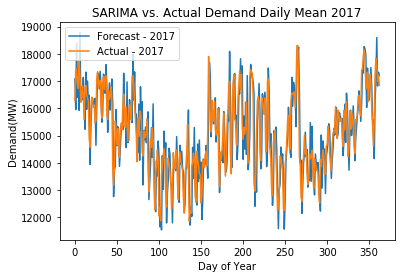

In [13]:
error = []

for i in range(0,364):
    
    error.append((test[i] - results[i]).abs())
    

r1 = 1
r2 = 364
plt.ylabel('Demand(MW)')
plt.xlabel('Day of Year')
plt.title('SARIMA vs. Actual Demand Daily Mean 2017')
plt.plot(results[r1:r2])
plt.plot(test[r1:r2])
plt.legend(['Forecast - 2017','Actual - 2017'], loc =2)

from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test[r1:r2], results[r1:r2]))
print(rms)
print(np.mean(error[r1:r2]))


In [36]:
trans

[               Total
 Date_Hour           
 2016-01-01       NaN
 2016-01-02       NaN
 2016-01-03       NaN
 2016-01-04       NaN
 2016-01-05       NaN
 2016-01-06       NaN
 2016-01-07       NaN
 2016-01-08       NaN
 2016-01-09       NaN
 2016-01-10       NaN
 2016-01-11       NaN
 2016-01-12       NaN
 2016-01-13  0.221031
 2016-01-14  0.189569
 2016-01-15  0.124646
 2016-01-16 -0.094891
 2016-01-17 -0.109835
 2016-01-18  0.052631
 2016-01-19  0.087200
 2016-01-20  0.076148
 2016-01-21  0.141670
 2016-01-22  0.129441
 2016-01-23 -0.069272
 2016-01-24 -0.091811
 2016-01-25 -0.063370
 2016-01-26 -0.084387
 2016-01-27 -0.032814
 2016-01-28  0.060155
 2016-01-29  0.049442
 2016-01-30 -0.125409
 ...              ...
 2016-12-06 -0.029566
 2016-12-07  0.007069
 2016-12-08  0.103854
 2016-12-09  0.139434
 2016-12-10  0.034182
 2016-12-11  0.049285
 2016-12-12  0.087615
 2016-12-13  0.102673
 2016-12-14  0.115441
 2016-12-15  0.194029
 2016-12-16  0.198712
 2016-12-17  0.044660
 2016-12-1

C:\Users\trevo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
C:\Users\trevo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


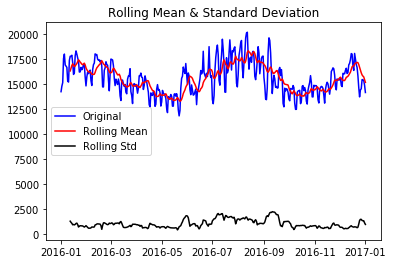

Results of Dickey-Fuller Test:
Test Statistic                  -1.814023
p-value                          0.373522
#Lags Used                      17.000000
Number of Observations Used    349.000000
Critical Value (1%)             -3.449227
Critical Value (5%)             -2.869857
Critical Value (10%)            -2.571201
dtype: float64


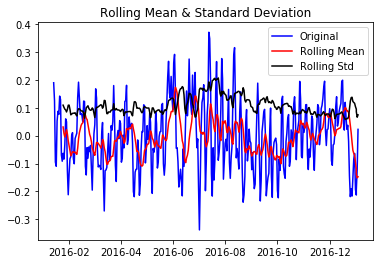

Results of Dickey-Fuller Test:
Test Statistic                  -2.638034
p-value                          0.085388
#Lags Used                      17.000000
Number of Observations Used    339.000000
Critical Value (1%)             -3.449788
Critical Value (5%)             -2.870104
Critical Value (10%)            -2.571332
dtype: float64


In [41]:
test_stationarity(demand2016.Total)
test_stationarity(trans[0].Total.iloc[13:])


In [ ]:
#find SARIMAX with optimal hyperparameters

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dTot_train_log_ewma,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-1824.0954844715936
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:-1790.179947552922
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-1726.3471784421533
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:-1703.9427906136634
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:-1115.129819714417
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-1822.3404690031432
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-1822.5562158387256
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:-1792.6634300618641
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-1387.3474290601107
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-1733.5031954195051
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:-1701.9678310914665
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:-730.7049383648155
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:-1299.5806631792393
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:-1564.7120533351426
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:-1804.1589782237302
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:-1806.2677710694027
ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:-1878.1226166706463
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - A

In [29]:
mod = sm.tsa.statespace.SARIMAX(dTot_train_log_ewma,
                                order=(2, 2, 0),
                                seasonal_order=(0, 3, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Total   No. Observations:                  738
Model:             SARIMAX(2, 2, 0)x(0, 3, 0, 12)   Log Likelihood                  -0.134
Date:                            Tue, 20 Mar 2018   AIC                              6.268
Time:                                    16:36:17   BIC                             20.080
Sample:                                01-01-2015   HQIC                            11.594
                                     - 01-06-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4110      0.026    -15.832      0.000      -0.462      -0.360
ar.L2         -0.6734      0.029   

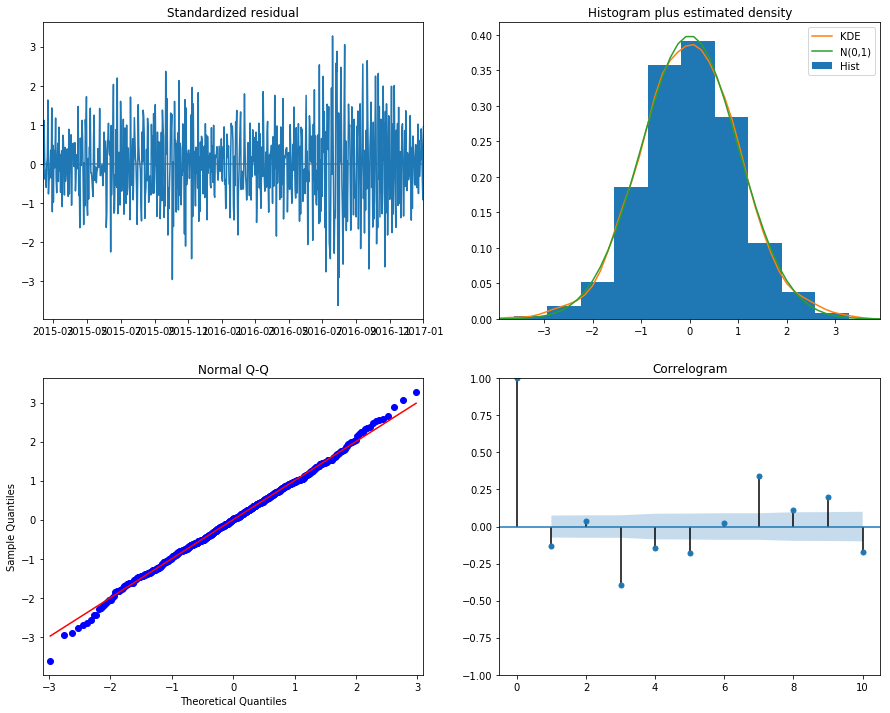

In [88]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()